x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 43s 720us/sample - loss: 2.2933 - accuracy: 0.1278 - val_loss: 2.2817 - val_accuracy: 0.1952
Epoch 2/12
60000/60000 [==============================] - 45s 747us/sample - loss: 2.2757 - accuracy: 0.1834 - val_loss: 2.2616 - val_accuracy: 0.2953
Epoch 3/12
60000/60000 [==============================] - 44s 727us/sample - loss: 2.2562 - accuracy: 0.2352 - val_loss: 2.2374 - val_accuracy: 0.3582
Epoch 4/12
60000/60000 [==============================] - 44s 728us/sample - loss: 2.2305 - accuracy: 0.2795 - val_loss: 2.2064 - val_accuracy: 0.3996
Epoch 5/12
60000/60000 [==============================] - 44s 738us/sample - loss: 2.1982 - accuracy: 0.3146 - val_loss: 2.1661 - val_accuracy: 0.4303
Epoch 6/12
60000/60000 [==============================] - 44s 731us/sample - loss: 2.1552 - accuracy: 0.3468 - val_loss: 2

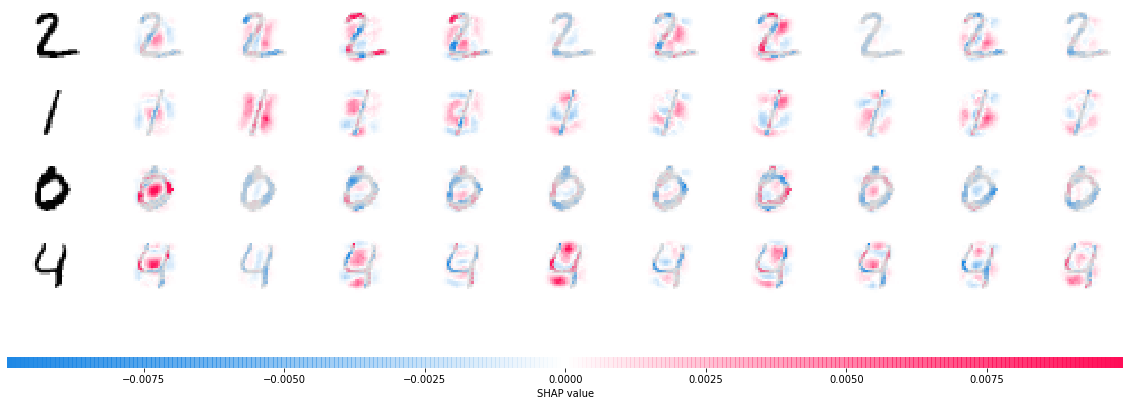

In [4]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
#import keras
#from keras.datasets import mnist
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from keras import backend as K
### Note: all instances of keras.something in the code below
### changed to tf.keras.something
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12 # original: 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
### Note the sigmoid here instead of softmax,
### resulting in slightly lower classifier accuracy ###
model.add(Dense(num_classes, activation='sigmoid'))

#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=keras.optimizers.Adadelta(),
#              metrics=['accuracy'])
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

import shap
import numpy as np

background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(x_test[1:5])
# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])